In [440]:
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Derivatives for the differential equation (acceleration due to gravity) wrt the position vector

In [441]:
mu = 1.0
# mu = 3.986004418e14

def function(p_vec):
    p_norm = np.linalg.norm(p_vec)
    return -mu * p_vec / p_norm**3

def first_order_partial_derivatives(p_vec):
    n = len(p_vec)
    p_norm = np.linalg.norm(p_vec)
    return -mu * (np.eye(n) / p_norm**3 - 3 * np.outer(p_vec, p_vec) / p_norm**5)

def second_order_partial_derivatives(p_vec):
    n = len(p_vec)
    p_norm = np.linalg.norm(p_vec)
    return -mu * (-3 / p_norm**5 * (np.outer(np.eye(n), p_vec) + np.kron(np.eye(n), p_vec) + np.kron(p_vec, np.eye(n))) + 15 / p_norm**7 * np.kron(p_vec, np.outer(p_vec, p_vec))) 

In [442]:
p1, p2, p3 = sp.symbols('p1 p2 p3')
p_vec = sp.Matrix([p1, p2, p3])
p_norm = sp.sqrt(p1**2 + p2**2 + p3**2)
fun = -mu * p_vec / p_norm**3
first_order_der = fun.jacobian(p_vec)
first_order_der_fun = sp.lambdify(p_vec, sp.ImmutableDenseNDimArray(first_order_der).tolist(), 'numpy')
second_order_der = sp.Matrix(np.array(sp.derive_by_array(first_order_der, p_vec)).reshape((3*3, 3)))
second_order_der_fun = sp.lambdify(p_vec, sp.ImmutableDenseNDimArray(second_order_der).tolist(), 'numpy')

# Example point
std = 1e-1
sample_p_vec = np.random.multivariate_normal(mean=np.zeros(3,), cov=std*np.eye(3)).reshape((3, 1))

# First Order Partial Derivatives Comparison
first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_p_vec)).reshape((3, 3))
first_order_partial_derivatives_analytical = first_order_partial_derivatives(sample_p_vec)
print(np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6))

# Second Order Partial Derivatives Comparison
second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_p_vec)).reshape((3*3, 3))
second_order_partial_derivatives_analytical = second_order_partial_derivatives(sample_p_vec)
print(np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6))

M = 100
all_close_results = []
for _ in range(M):
    sample_p_vec = np.random.multivariate_normal(mean=np.zeros(3,), cov=std*np.eye(3)).reshape((3, 1))
    first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_p_vec)).reshape((3, 3))
    first_order_partial_derivatives_analytical = first_order_partial_derivatives(sample_p_vec)
    second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_p_vec)).reshape((3*3, 3))
    second_order_partial_derivatives_analytical = second_order_partial_derivatives(sample_p_vec)
    all_close = np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6) and np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6)
    all_close_results.append(all_close)
print(f"All Cases Passed?: {all(all_close_results)}")

True
True
All Cases Passed?: True


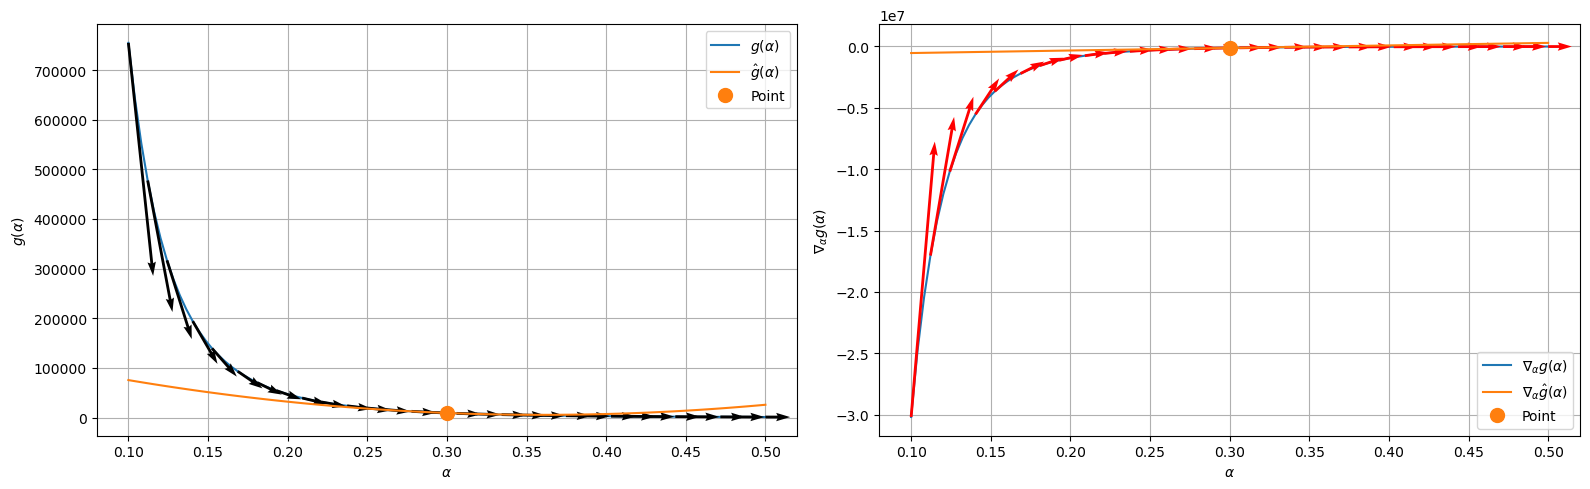

In [443]:
def test_function(alpha, p_vec):
    cost = function(alpha * p_vec)
    return 1 / 2 * np.linalg.norm(cost)**2

def test_function_grad(alpha, p_vec):
    cost = function(alpha * p_vec)
    jacobian = first_order_partial_derivatives(alpha * p_vec)
    return cost.T @ jacobian @ p_vec

def test_function_hessian(alpha, p_vec):
    n = len(p_vec)
    cost = function(alpha * p_vec)
    jacobian = first_order_partial_derivatives(alpha * p_vec)
    hessian = second_order_partial_derivatives(alpha * p_vec)
    return cost.T @ np.kron(p_vec, np.eye(n)).T @ hessian @ p_vec + p_vec.T @ jacobian.T @ jacobian @ p_vec

def test_function_approx(alpha, p_vec, point=0):
    return test_function(point, p_vec) + (alpha - point) * test_function_grad(point, p_vec) + (alpha - point)**2 / 2 * test_function_hessian(point, p_vec)

def test_function_approx_grad(alpha, p_vec, point=0):
    return test_function_grad(point, p_vec) + (alpha - point) * test_function_hessian(point, p_vec)

std = 1e0
sample_p_vec = np.random.multivariate_normal(mean=np.zeros(3,), cov=std*np.eye(3)).reshape((3, 1))

alpha_bounds = np.linspace(1e-1, 5e-1, 100)
point = np.mean(alpha_bounds)
cost_values = np.array([test_function(alpha, sample_p_vec) for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(alpha, sample_p_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_cost_function = np.array([test_function_approx(alpha, sample_p_vec, point=point).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_cost_function_grad = np.array([test_function_approx_grad(alpha, sample_p_vec, point=point).flatten() for alpha in alpha_bounds])

# Arrows
num_arrows = 30
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

# Plot function and gradient
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$g(\alpha)$')
axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
               np.ones_like(arrow_indices), gradient_values[arrow_indices], 
               angles='xy', scale_units='xy', color='black', width=0.004, zorder=2)
axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_cost_function, label=r'$\hat{g}(\alpha)$', zorder=3)
axes[0].plot(point, test_function(point, sample_p_vec), 'o', label='Point', color='C1', markersize=10, zorder=4)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$g(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\nabla_\alpha g(\alpha)$')
axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
               np.ones_like(arrow_indices), hessian_values[arrow_indices], 
               angles='xy', scale_units='xy', color='red', width=0.004, zorder=2)
axes[1].plot(alpha_bounds, taylor_series_second_order_expansion_cost_function_grad, label=r'$\nabla_\alpha \hat{g}(\alpha)$', zorder=3)
axes[1].plot(point, test_function_grad(point, sample_p_vec), 'o', label='Point', color='C1', markersize=10, zorder=4)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\nabla_\alpha g(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

### Derivatives for the differential equation (acceleration due to gravity) wrt the state vector for one agent

In [444]:
def differential_equation(x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    return np.concatenate((v_vec, function(p_vec)))

def first_order_partial_derivatives_for_the_differential_equation(x_vec):
    first_order_pder = np.zeros((6, 6))
    p_vec = x_vec[:3]
    first_order_pder[:3, 3:] = np.eye(3)
    first_order_pder[3:, :3] = first_order_partial_derivatives(p_vec)
    return first_order_pder

def second_order_partial_derivatives_for_the_differential_equation(x_vec):
    second_order_pder = np.zeros((6 * 6, 6))
    p_vec = x_vec[:3]
    aux = second_order_partial_derivatives(p_vec)
    for i in range(3):
        second_order_pder[6*i+3:6*i+6, :3] = aux[i*3:i*3+3, :]
    return second_order_pder

In [445]:
# Symbolic
p1, p2, p3, v1, v2, v3 = sp.symbols('p1 p2 p3 v1 v2 v3')
p_vec = sp.Matrix([p1, p2, p3])
v_vec = sp.Matrix([v1, v2, v3])
x_vec = sp.Matrix([p1, p2, p3, v1, v2, v3])
p_norm = sp.sqrt(p1**2 + p2**2 + p3**2)
fun = sp.Matrix.vstack(v_vec, -mu * p_vec / p_norm**3)
first_order_der = fun.jacobian(x_vec)
first_order_der_fun = sp.lambdify(x_vec, sp.ImmutableDenseNDimArray(first_order_der).tolist(), 'numpy')
second_order_der = sp.Matrix(np.array(sp.derive_by_array(first_order_der, x_vec)).reshape((6*6, 6)))
second_order_der_fun = sp.lambdify(x_vec, sp.ImmutableDenseNDimArray(second_order_der).tolist(), 'numpy')

# Example point
std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))

# First Order Partial Derivatives Comparison
first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_x_vec.flatten()))
first_order_partial_derivatives_analytical = first_order_partial_derivatives_for_the_differential_equation(sample_x_vec)
print(np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6))

# Second Order Partial Derivatives Comparison
second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_x_vec.flatten()))
second_order_partial_derivatives_analytical = second_order_partial_derivatives_for_the_differential_equation(sample_x_vec)
print(np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6))

M = 100
all_close_results = []
for _ in range(M):
    sample_x_vec = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))
    first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_x_vec.flatten()))
    first_order_partial_derivatives_analytical = first_order_partial_derivatives_for_the_differential_equation(sample_x_vec)
    second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_x_vec.flatten()))
    second_order_partial_derivatives_analytical = second_order_partial_derivatives_for_the_differential_equation(sample_x_vec)
    all_close = np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6) and np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6)
    all_close_results.append(all_close)
print(f"All Cases Passed?: {all(all_close_results)}")

True
True
All Cases Passed?: True


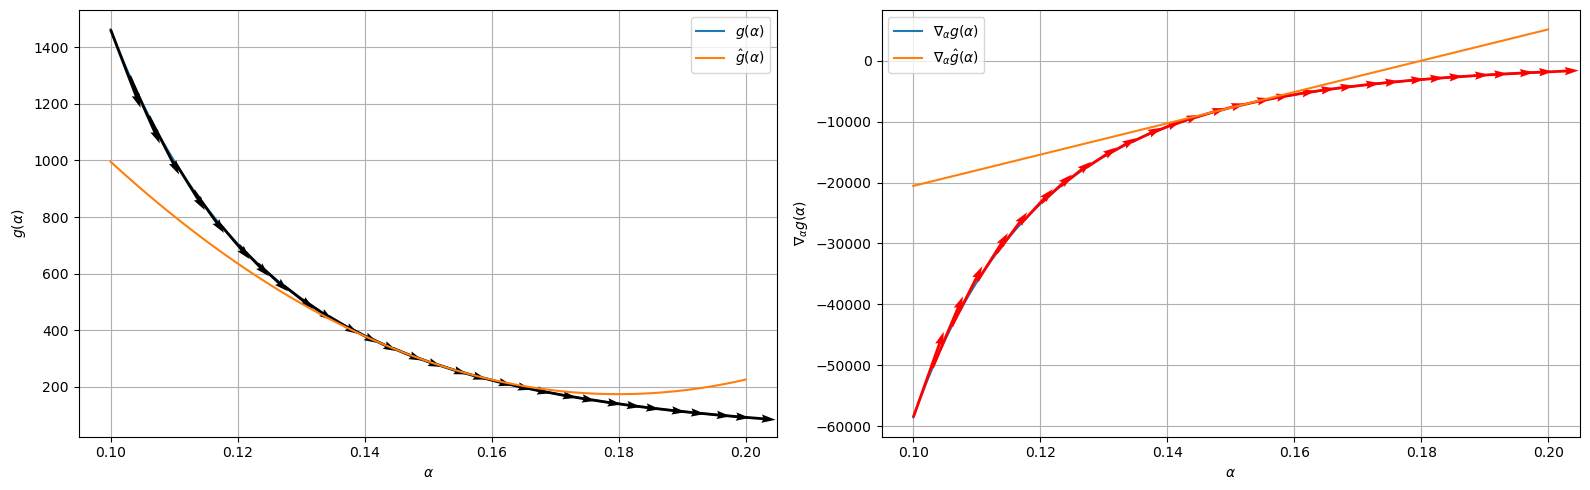

In [446]:
def test_function(alpha, x_vec):
    cost = differential_equation(alpha * x_vec)
    return 1 / 2 * np.linalg.norm(cost)**2

def test_function_grad(alpha, x_vec):
    cost = differential_equation(alpha * x_vec)
    jacobian = first_order_partial_derivatives_for_the_differential_equation(alpha * x_vec)
    return cost.T @ jacobian @ x_vec

def test_function_hessian(alpha, x_vec):
    n = len(x_vec)
    cost = differential_equation(alpha * x_vec)
    jacobian = first_order_partial_derivatives_for_the_differential_equation(alpha * x_vec)
    hessian = second_order_partial_derivatives_for_the_differential_equation(alpha * x_vec)
    cost.T @ np.einsum('ijk,k->ij', hessian.reshape((n, n, n)), x_vec.flatten()) @ x_vec
    # return cost.T @ np.einsum('ijk,k->ij', hessian.reshape((n, n, n)), x_vec.flatten()).T @ x_vec + x_vec.T @ jacobian.T @ jacobian @ x_vec # Which is also the same
    return cost.T @ np.kron(x_vec, np.eye(n)).T @ hessian @ x_vec + x_vec.T @ jacobian.T @ jacobian @ x_vec

def test_function_approx(alpha, x_vec, point=0):
    return test_function(point, x_vec) + (alpha - point) * test_function_grad(point, x_vec) + (alpha - point)**2 / 2 * test_function_hessian(point, x_vec)

def test_function_approx_grad(alpha, x_vec, point=0):
    return test_function_grad(point, x_vec) + (alpha - point) * test_function_hessian(point, x_vec)

std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))

alpha_bounds = np.linspace(1e-1, 2e-1, 100)
cost_values = np.array([test_function(alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_cost_function = np.array([test_function_approx(alpha, sample_x_vec, point=np.mean(alpha_bounds)).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_cost_function_grad = np.array([test_function_approx_grad(alpha, sample_x_vec, point=np.mean(alpha_bounds)).flatten() for alpha in alpha_bounds])

# Arrows
num_arrows = 30
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

# Plot function and gradient
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$g(\alpha)$')
axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
               np.ones_like(arrow_indices), gradient_values[arrow_indices], 
               angles='xy', scale_units='xy', color='black', width=0.004, zorder=2)
axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_cost_function, label=r'$\hat{g}(\alpha)$', zorder=3)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$g(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\nabla_\alpha g(\alpha)$')
axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
               np.ones_like(arrow_indices), hessian_values[arrow_indices], 
               angles='xy', scale_units='xy', color='red', width=0.004, zorder=2)
axes[1].plot(alpha_bounds, taylor_series_second_order_expansion_cost_function_grad, label=r'$\nabla_\alpha \hat{g}(\alpha)$', zorder=3)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\nabla_\alpha g(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

### Derivatives for the differential equation (acceleration due to gravity) wrt the total state vector

In [447]:
def total_differential_equation(x_vec):
    x_dot_vec = np.zeros_like(x_vec)
    for i in range(x_vec.shape[0] // 6):
        p_vec = x_vec[i * 6 : i * 6 + 3] 
        v_vec = x_vec[i * 6 + 3 : i * 6 + 6]
        x_dot_vec[i * 6 : i * 6 + 6] = np.concatenate((v_vec, function(p_vec)))
    return x_dot_vec

def total_first_order_partial_derivatives_for_the_differential_equation(x_vec):
    first_order_der = np.zeros((x_vec.shape[0], x_vec.shape[0]))
    
    for i in range(x_vec.shape[0] // 6):
        p_vec = x_vec[i * 6 : i * 6 + 3] 
        first_order_der[i * 6 : i * 6 + 3, i * 6 + 3 : i * 6 + 6] = np.eye(3)
        first_order_der[i * 6 + 3 : i * 6 + 6, i * 6 : i * 6 + 3] = first_order_partial_derivatives(p_vec)
    return first_order_der

def total_second_order_partial_derivatives_for_the_differential_equation(x_vec):
    second_order_der = np.zeros((x_vec.shape[0] * x_vec.shape[0], x_vec.shape[0]))

    for i in range(x_vec.shape[0] // 6):
        p_vec = x_vec[i * 6 : i * 6 + 3]
        aux = second_order_partial_derivatives(p_vec)

        # Populate the second-order derivative tensor correctly
        for j in range(3):  # Iterate over the 3D position components
            second_order_der[24 * (6 * i + j) + 6 * i + 3 : 24 * (6 * i + j) + 6 * i + 6, 6 * i : 6 * i + 3] = aux[3 * j:3 * (j + 1), :]

    return second_order_der

In [448]:
# Symbolic
p11, p12, p13, v11, v12, v13, p21, p22, p23, v21, v22, v23, p31, p32, p33, v31, v32, v33, p41, p42, p43, v41, v42, v43 = sp.symbols('p11 p12 p13 v11 v12 v13 p21 p22 p23 v21 v22 v23 p31 p32 p33 v31 v32 v33 p41 p42 p43 v41 v42 v43')
p_vec_1 = sp.Matrix([p11, p12, p13])
p_norm_1 = sp.sqrt(p11**2 + p12**2 + p13**2)
v_vec_1 = sp.Matrix([v11, v12, v13])
x_vec_1 = sp.Matrix([p11, p12, p13, v11, v12, v13])
p_vec_2 = sp.Matrix([p21, p22, p23])
p_norm_2 = sp.sqrt(p21**2 + p22**2 + p23**2)
v_vec_2 = sp.Matrix([v21, v22, v23])
x_vec_2 = sp.Matrix([p21, p22, p23, v21, v22, v23])
p_vec_3 = sp.Matrix([p31, p32, p33])
p_norm_3 = sp.sqrt(p31**2 + p32**2 + p33**2)
v_vec_3 = sp.Matrix([v31, v32, v33])
x_vec_3 = sp.Matrix([p31, p32, p33, v31, v32, v33])
p_vec_4 = sp.Matrix([p41, p42, p43])
p_norm_4 = sp.sqrt(p41**2 + p42**2 + p43**2)
v_vec_4 = sp.Matrix([v41, v42, v43])
x_vec_4 = sp.Matrix([p41, p42, p43, v41, v42, v43])
x_vec = sp.Matrix([x_vec_1, x_vec_2, x_vec_3, x_vec_4])
fun_1 = sp.Matrix.vstack(v_vec_1, -mu * p_vec_1 / p_norm_1**3)
fun_2 = sp.Matrix.vstack(v_vec_2, -mu * p_vec_2 / p_norm_2**3)
fun_3 = sp.Matrix.vstack(v_vec_3, -mu * p_vec_3 / p_norm_3**3)
fun_4 = sp.Matrix.vstack(v_vec_4, -mu * p_vec_4 / p_norm_4**3)
fun = sp.Matrix.vstack(fun_1, fun_2, fun_3, fun_4)
first_order_der = fun.jacobian(x_vec)
first_order_der_fun = sp.lambdify(x_vec, sp.ImmutableDenseNDimArray(first_order_der).tolist(), 'numpy')
second_order_der = sp.Matrix(np.array(sp.derive_by_array(first_order_der, x_vec)).reshape((24*24, 24)))
second_order_der_fun = sp.lambdify(x_vec, sp.ImmutableDenseNDimArray(second_order_der).tolist(), 'numpy')

# Example point
std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(24,), cov=std*np.eye(24)).reshape((24, 1))

# # First Order Partial Derivatives Comparison
first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_x_vec.flatten()))
first_order_partial_derivatives_analytical = total_first_order_partial_derivatives_for_the_differential_equation(sample_x_vec)
print(np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6))

# # Second Order Partial Derivatives Comparison
second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_x_vec.flatten()))
second_order_partial_derivatives_analytical = total_second_order_partial_derivatives_for_the_differential_equation(sample_x_vec)
print(np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6))

M = 100
all_close_results = []
for _ in range(M):
    sample_x_vec = np.random.multivariate_normal(mean=np.zeros(24,), cov=std*np.eye(24)).reshape((24, 1))
    first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_x_vec.flatten()))
    first_order_partial_derivatives_analytical = total_first_order_partial_derivatives_for_the_differential_equation(sample_x_vec)
    second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_x_vec.flatten()))
    second_order_partial_derivatives_analytical = total_second_order_partial_derivatives_for_the_differential_equation(sample_x_vec)
    all_close = np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6) and np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6)
    all_close_results.append(all_close)
print(f"All Cases Passed?: {all(all_close_results)}")

True
True
All Cases Passed?: True


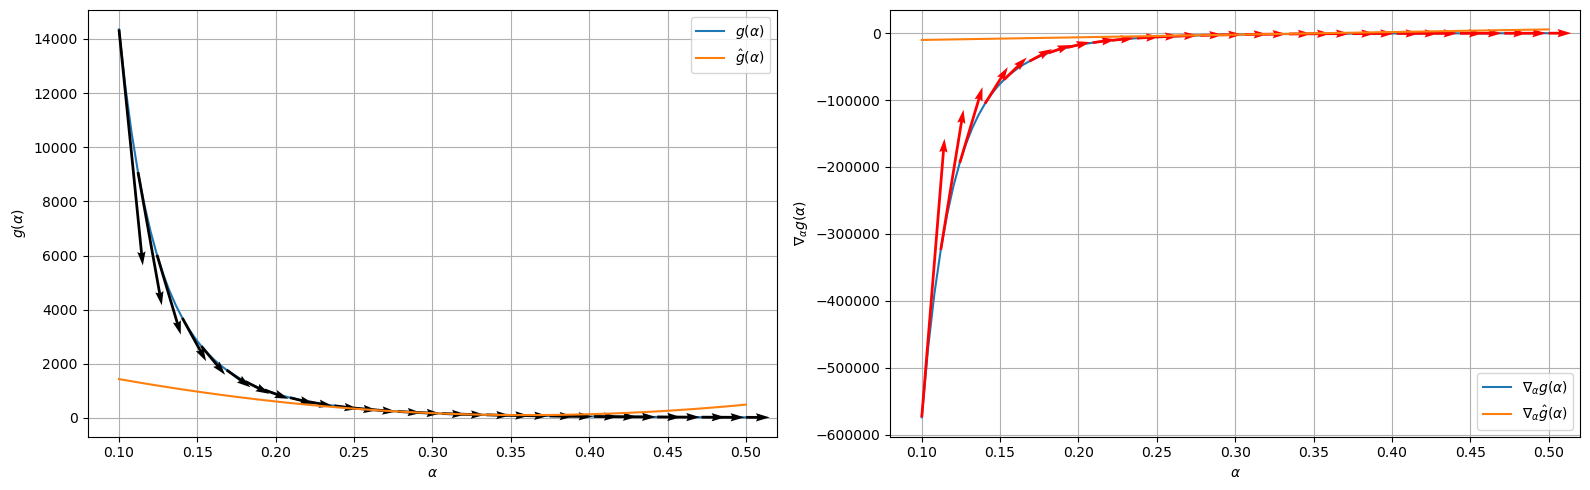

In [449]:
def test_function(alpha, x_vec):
    cost = total_differential_equation(alpha * x_vec)
    return 1 / 2 * np.linalg.norm(cost)**2

def test_function_grad(alpha, x_vec):
    cost = total_differential_equation(alpha * x_vec)
    jacobian = total_first_order_partial_derivatives_for_the_differential_equation(alpha * x_vec)
    return cost.T @ jacobian @ x_vec

def test_function_hessian(alpha, x_vec):
    n = len(x_vec)
    cost = total_differential_equation(alpha * x_vec)
    jacobian = total_first_order_partial_derivatives_for_the_differential_equation(alpha * x_vec)
    hessian = total_second_order_partial_derivatives_for_the_differential_equation(alpha * x_vec)
    return cost.T @ np.kron(x_vec, np.eye(n)).T @ hessian @ x_vec + x_vec.T @ jacobian.T @ jacobian @ x_vec

def test_function_approx(alpha, x_vec, point=0):
    return test_function(point, x_vec) + (alpha - point) * test_function_grad(point, x_vec) + (alpha - point)**2 / 2 * test_function_hessian(point, x_vec)

def test_function_approx_grad(alpha, x_vec, point=0):
    return test_function_grad(point, x_vec) + (alpha - point) * test_function_hessian(point, x_vec)

std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(24,), cov=std*np.eye(24)).reshape((24, 1))

alpha_bounds = np.linspace(1e-1, 5e-1, 100)
cost_values = np.array([test_function(alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_cost_function = np.array([test_function_approx(alpha, sample_x_vec, point=np.mean(alpha_bounds)).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_cost_function_grad = np.array([test_function_approx_grad(alpha, sample_x_vec, point=np.mean(alpha_bounds)).flatten() for alpha in alpha_bounds])

# Arrows
num_arrows = 30
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

# Plot function and gradient
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$g(\alpha)$')
axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
               np.ones_like(arrow_indices), gradient_values[arrow_indices], 
               angles='xy', scale_units='xy', color='black', width=0.004, zorder=2)
axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_cost_function, label=r'$\hat{g}(\alpha)$', zorder=3)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$g(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\nabla_\alpha g(\alpha)$')
axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
               np.ones_like(arrow_indices), hessian_values[arrow_indices], 
               angles='xy', scale_units='xy', color='red', width=0.004, zorder=2)
axes[1].plot(alpha_bounds, taylor_series_second_order_expansion_cost_function_grad, label=r'$\nabla_\alpha \hat{g}(\alpha)$', zorder=3)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\nabla_\alpha g(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

### Derivatives for the solution (single time-step propagation) of the differential equation (acceleration due to gravity) wrt the state vector for one agent

In [450]:
def f(dt, x_old):
    k1 = differential_equation(x_old)
    k2 = differential_equation(x_old + dt / 2 * k1)
    k3 = differential_equation(x_old + dt / 2 * k2)
    k4 = differential_equation(x_old + dt * k3)
    return x_old + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

def Df(dt, x_old):
    n = len(x_old)
    
    k1 = differential_equation(x_old)
    k2 = differential_equation(x_old + dt / 2 * k1)
    k3 = differential_equation(x_old + dt / 2 * k2)

    Dk1 = first_order_partial_derivatives_for_the_differential_equation(x_old)
    Dk2 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)
    Dk4 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3) @ (np.eye(n) + dt * Dk3)
    return np.eye(n) + dt / 6 * (Dk1 + 2 * Dk2 + 2 * Dk3 + Dk4)

def Hf(dt, x_old):
    n = len(x_old)
    
    k1 = differential_equation(x_old)
    k2 = differential_equation(x_old + dt / 2 * k1)
    k3 = differential_equation(x_old + dt / 2 * k2)

    Dk1 = first_order_partial_derivatives_for_the_differential_equation(x_old)
    Dk2 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)

    Hk1 = second_order_partial_derivatives_for_the_differential_equation(x_old)
    Hk2 = second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1) + np.kron(np.eye(n), first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1)) @ (dt / 2 * Hk1)
    Hk3 = second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2) + np.kron(np.eye(n), first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2)) @ (dt / 2 * Hk2)
    Hk4 = second_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3) @ (np.eye(n) + dt * Dk3) + np.kron(np.eye(n), first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3)) @ (dt * Hk3)
    return dt / 6 * (Hk1 + 2 * Hk2 + 2 * Hk3 + Hk4)

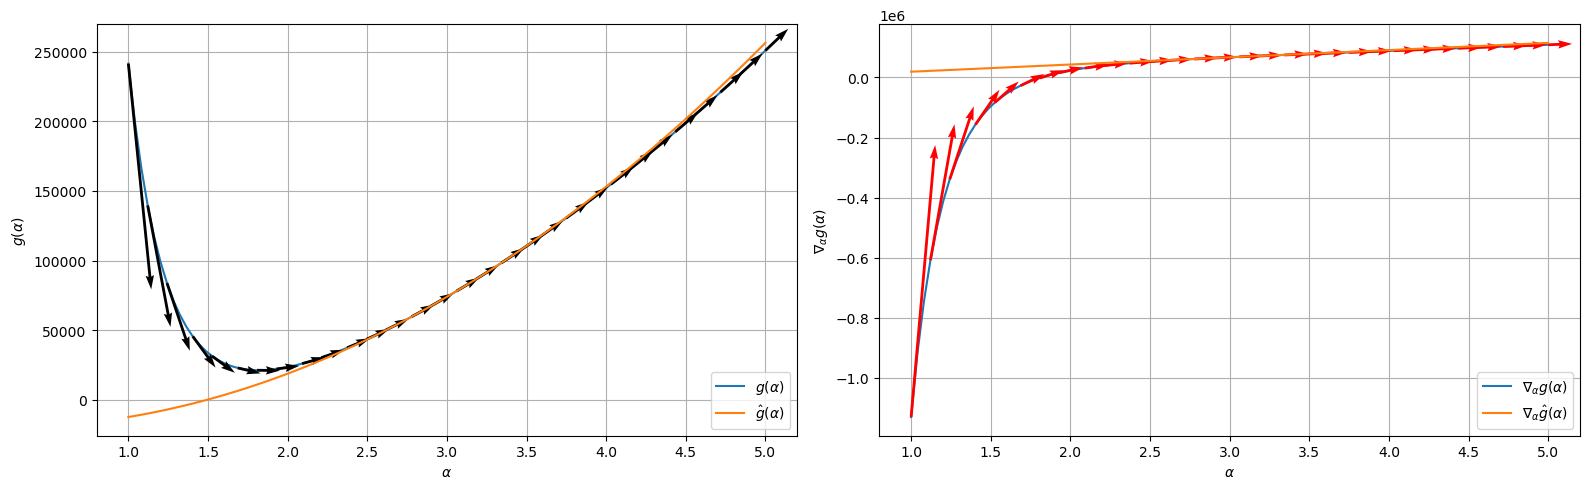

In [451]:
def test_function(dt, alpha, x_vec):
    cost = f(dt, alpha * x_vec)
    return 1 / 2 * np.linalg.norm(cost)**2

def test_function_grad(dt, alpha, x_vec):
    cost = f(dt, alpha * x_vec)
    jacobian = Df(dt, alpha * x_vec)
    return cost.T @ jacobian @ x_vec

def test_function_hessian(dt, alpha, x_vec):
    n = len(x_vec)
    cost = f(dt, alpha * x_vec)
    jacobian = Df(dt, alpha * x_vec)
    hessian = Hf(dt, alpha * x_vec)
    return cost.T @ np.kron(x_vec, np.eye(n)).T @ hessian @ x_vec + x_vec.T @ jacobian.T @ jacobian @ x_vec

def test_function_approx(dt, alpha, x_vec, point=0):
    return test_function(dt, point, x_vec) + (alpha - point) * test_function_grad(dt, point, x_vec) + (alpha - point)**2 / 2 * test_function_hessian(dt, point, x_vec)

def test_function_approx_grad(dt, alpha, x_vec, point=0):
    return test_function_grad(dt, point, x_vec) + (alpha - point) * test_function_hessian(dt, point, x_vec)

std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))

dt = 60.0
alpha_bounds = np.linspace(1e0, 5e0, 100)
cost_values = np.array([test_function(dt, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(dt, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(dt, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_cost_function = np.array([test_function_approx(dt, alpha, sample_x_vec, point=np.mean(alpha_bounds)).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_cost_function_grad = np.array([test_function_approx_grad(dt, alpha, sample_x_vec, point=np.mean(alpha_bounds)).flatten() for alpha in alpha_bounds])

# Arrows
num_arrows = 30
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

# Plot function and gradient
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$g(\alpha)$')
axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
               np.ones_like(arrow_indices), gradient_values[arrow_indices], 
               angles='xy', scale_units='xy', color='black', width=0.004, zorder=2)
axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_cost_function, label=r'$\hat{g}(\alpha)$', zorder=3)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$g(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\nabla_\alpha g(\alpha)$')
axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
               np.ones_like(arrow_indices), hessian_values[arrow_indices], 
               angles='xy', scale_units='xy', color='red', width=0.004, zorder=2)
axes[1].plot(alpha_bounds, taylor_series_second_order_expansion_cost_function_grad, label=r'$\nabla_\alpha \hat{g}(\alpha)$', zorder=3)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\nabla_\alpha g(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

### Derivatives for the solution (tau time-steps propagation) of the differential equation (acceleration due to gravity) wrt the state vector for one agent

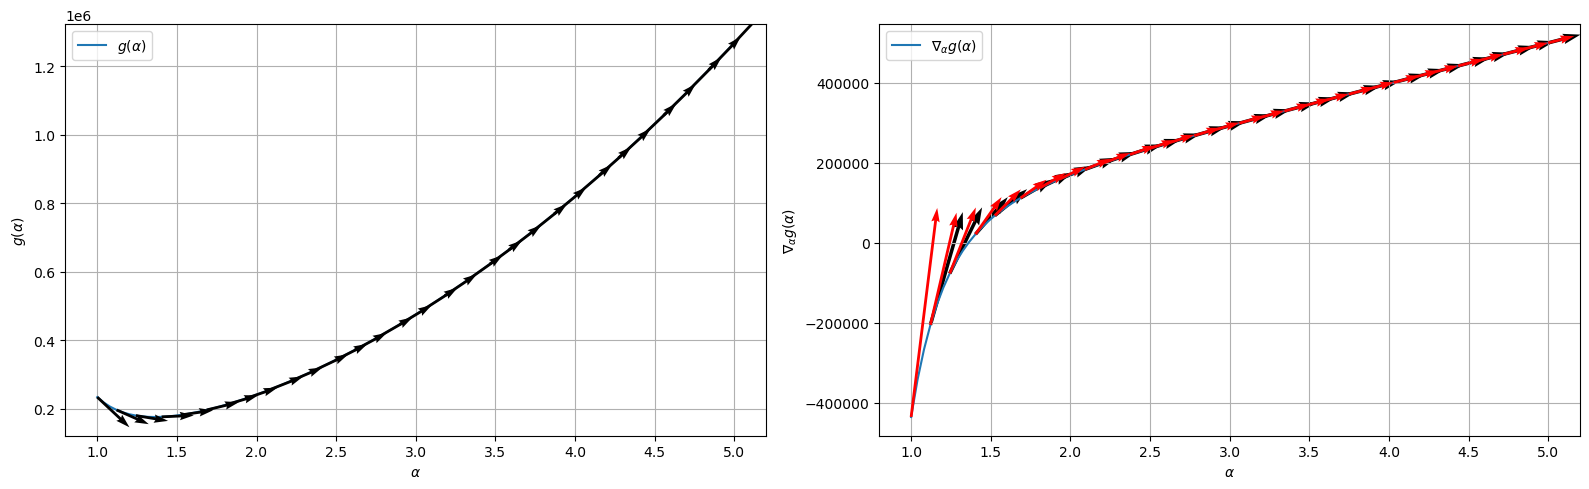

In [619]:
def test_function(tau, dt, alpha, x_vec):
    x_vec = alpha * x_vec
    for _ in range(tau):
        x_vec = f(dt, x_vec)
    return 1 / 2 * np.linalg.norm(x_vec)**2

def test_function_grad(tau, dt, alpha, x_vec):
    x_initial = x_vec
    x_vec = alpha * x_vec
    n = len(x_vec)
    STM = np.eye(n)
    for _ in range(tau):
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    return x_vec.T @ STM @ x_initial

def test_function_hessian(tau, dt, alpha, x_vec):
    x_initial = x_vec
    x_vec = alpha * x_vec
    n = len(x_vec)
    STM = np.eye(n)
    DSTM = np.zeros((n * n, n))
    hessian = 0
    for _ in range(tau):
        DSTM += np.kron(np.eye(n), STM).T @ Hf(dt, x_vec) @ STM + np.kron(Df(dt, x_vec), np.eye(n)) @ DSTM
        STM = Df(dt, x_vec) @ STM
        x_vec = f(dt, x_vec)
    hessian += x_vec.T @ np.kron(x_initial, np.eye(n)).T @ DSTM @ x_initial + x_initial.T @ STM.T @ STM @ x_initial
    # if tau == 0:
    #     STM = np.eye(n)
    #     hessian += x_initial.T @ STM.T @ STM @ x_initial
    #     DSTM = np.zeros((n * n, n))
    #     hessian += x_initial.T @ np.kron(x_initial, np.eye(n)).T @ DSTM @ x_initial
    # elif tau == 1:
    #     f_x = f(dt, alpha * x_initial)
    #     Df_x = Df(dt, alpha * x_initial)
    #     Hf_x = Hf(dt, alpha * x_initial)
    #     STM = Df_x @ np.eye(n)
    #     hessian += x_initial.T @ STM.T @ STM @ x_initial
    #     DSTM = Hf_x
    #     hessian += f_x.T @ np.kron(x_initial, np.eye(n)).T @ DSTM @ x_initial
    #     # 1/2 (f[alpha x].(x^2 Hf_x)+2 (x Df_x).(x Df_x)+(x^2 Hf_x).f[alpha x]) 
    #     # f_x.T @ np.kron(x_initial, np.eye(n)).T (Hf_x) @ x_initial + x_initial.T @ Df_x.T @ Df_x @ x_initial
    # elif tau == 2:
    #     f_x = f(dt, alpha * x_initial)
    #     f_after_f_x = f(dt, f_x)
    #     Df_x = Df(dt, alpha * x_initial)
    #     Df_after_f_x = Df(dt, f_x)
    #     Hf_x = Hf(dt, alpha * x_initial)
    #     Hf_after_f_x = Hf(dt, f_x)
    #     STM = Df_after_f_x @ Df_x @ np.eye(n)
    #     hessian += x_initial.T @ STM.T @ STM @ x_initial
    #     DSTM = Hf_x
    #     DSTM += np.kron(np.eye(n), Df_x).T @ Hf_after_f_x @ Df_x + np.kron(Df_after_f_x, np.eye(n)) @ Hf_x
    #     hessian += f_after_f_x.T @ np.kron(x_initial, np.eye(n)).T @ DSTM @ x_initial
    #     # 1/2 (f[f[alpha x]].(x^2 (Df_after_f_x Hf_x+Df_x^2 Hf_after_f_x))+2 (x Df_x Df_after_f_x).(x Df_x Df_after_f_x)+(x^2 (Df_after_f_x Hf_x+Df_x^2 Hf_after_f_x)).f[f[alpha x]]) 
    #     # f_after_f_x.T @ np.kron(x_initial, np.eye(n)).T @ (np.kron(np.eye(n), Df_x).T @ Hf_after_f_x @ Df_x + np.kron(Df_after_f_x, np.eye(n)) @ Hf_x) @ x_initial + x_initial.T @ (Df_after_f_x @ Df_x).T @ (Df_after_f_x @ Df_x) @ x_initial
    # elif tau == 3:
    #     f_x = f(dt, alpha * x_initial)
    #     f_after_f_x = f(dt, f_x)
    #     f_after_f_after_f_x = f(dt, f_after_f_x)
    #     Df_x = Df(dt, alpha * x_initial)
    #     Df_after_f_x = Df(dt, f_x)
    #     Df_after_f_after_f_x = Df(dt, f_after_f_x)
    #     Hf_x = Hf(dt, alpha * x_initial)
    #     Hf_after_f_x = Hf(dt, f_x)
    #     Hf_after_f_after_f_x = Hf(dt, f_after_f_x)
    #     STM = Df_after_f_after_f_x @ Df_after_f_x @ Df_x @ np.eye(n)
    #     hessian += x_initial.T @ STM.T @ STM @ x_initial
    #     DSTM = Hf_x
    #     DSTM += np.kron(np.eye(n), Df_x).T @ Hf_after_f_x @ Df_x + np.kron(Df_after_f_x, np.eye(n)) @ Hf_x 
    #     DSTM += np.kron(np.eye(n), Df_after_f_x @ Df_x).T @ Hf_after_f_after_f_x @ Df_after_f_x @ Df_x + np.kron(Df_after_f_after_f_x, np.eye(n)) @ (np.kron(np.eye(n), Df_x).T @ Hf_after_f_x @ Df_x + np.kron(Df_after_f_x, np.eye(n)) @ Hf_x)
    #     hessian += f_after_f_after_f_x.T @ np.kron(x_initial, np.eye(n)).T @ DSTM @ x_initial
    return hessian

def test_function_approx(tau, dt, alpha, x_vec, point=0):
    return test_function(tau, dt, point, x_vec) + (alpha - point) * test_function_grad(tau, dt, point, x_vec) + (alpha - point)**2 / 2 * test_function_hessian(tau, dt, point, x_vec)

def test_function_approx_grad(tau, dt, alpha, x_vec, point=0):
    return test_function_grad(tau, dt, point, x_vec) + (alpha - point) * test_function_hessian(tau, dt, point, x_vec)

std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(6,), cov=std*np.eye(6)).reshape((6, 1))

tau = 3
dt = 60.0
alpha_bounds = np.linspace(1e0, 5e0, 100)
cost_values = np.array([test_function(tau, dt, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(tau, dt, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([(test_function_hessian(tau, dt, alpha, sample_x_vec)).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_cost_function = np.array([test_function_approx(tau, dt, alpha, sample_x_vec, point=np.mean(alpha_bounds)).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_cost_function_grad = np.array([test_function_approx_grad(tau, dt, alpha, sample_x_vec, point=np.mean(alpha_bounds)).flatten() for alpha in alpha_bounds])

# Arrows
num_arrows = 30
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

def compute_tangent_slope(x, y, idx):
    """Compute the slope of the tangent line at a given index idx."""
    if idx == 0:
        slope = (y[idx + 1] - y[idx]) / (x[idx + 1] - x[idx])
    elif idx == len(x) - 1:
        slope = (y[idx] - y[idx - 1]) / (x[idx] - x[idx - 1])
    else:
        slope = (y[idx + 1] - y[idx - 1]) / (x[idx + 1] - x[idx - 1])

    return slope
x = alpha_bounds
y = gradient_values
slopes = [compute_tangent_slope(x, y, idx) for idx in arrow_indices]
dy = np.array(slopes)

# Plot function and gradient
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$g(\alpha)$')
axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
               np.ones_like(arrow_indices), gradient_values[arrow_indices], 
               angles='xy', scale_units='xy', color='black', width=0.004, zorder=2)
# axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_cost_function, label=r'$\hat{g}(\alpha)$', zorder=3)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$g(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\nabla_\alpha g(\alpha)$')
axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
               np.ones_like(arrow_indices), hessian_values[arrow_indices], 
               angles='xy', scale_units='xy', color='red', width=0.004, zorder=2)
axes[1].quiver(alpha_bounds[arrow_indices][1:], gradient_values[arrow_indices][1:], np.ones_like(arrow_indices[1:]), dy[1:], angles="xy", scale_units="xy", color="black", width=0.005)
# axes[1].plot(alpha_bounds, taylor_series_second_order_expansion_cost_function_grad, label=r'$\nabla_\alpha \hat{g}(\alpha)$', zorder=3)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\nabla_\alpha g(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

### Derivatives for the solution (single time-step propagation) of the differential equation (acceleration due to gravity) wrt the total state vector

In [331]:
def f(dt, x_old):
    k1 = total_differential_equation(x_old)
    k2 = total_differential_equation(x_old + dt / 2 * k1)
    k3 = total_differential_equation(x_old + dt / 2 * k2)
    k4 = total_differential_equation(x_old + dt * k3)
    return x_old + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

def Df(dt, x_old):
    n = len(x_old)
    
    k1 = total_differential_equation(x_old)
    k2 = total_differential_equation(x_old + dt / 2 * k1)
    k3 = total_differential_equation(x_old + dt / 2 * k2)

    Dk1 = total_first_order_partial_derivatives_for_the_differential_equation(x_old)
    Dk2 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)
    Dk4 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3) @ (np.eye(n) + dt * Dk3)
    return np.eye(n) + dt / 6 * (Dk1 + 2 * Dk2 + 2 * Dk3 + Dk4)

def Hf(dt, x_old):
    n = len(x_old)
    
    k1 = total_differential_equation(x_old)
    k2 = total_differential_equation(x_old + dt / 2 * k1)
    k3 = total_differential_equation(x_old + dt / 2 * k2)

    Dk1 = total_first_order_partial_derivatives_for_the_differential_equation(x_old)
    Dk2 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1)
    Dk3 = total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2)

    Hk1 = total_second_order_partial_derivatives_for_the_differential_equation(x_old)
    Hk2 = total_second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * Dk1) + np.kron(np.eye(n), total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1)) @ (dt / 2 * Hk1)
    Hk3 = total_second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * Dk2) + np.kron(np.eye(n), total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2)) @ (dt / 2 * Hk2)
    Hk4 = total_second_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3) @ (np.eye(n) + dt * Dk3) + np.kron(np.eye(n), total_first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3)) @ (dt * Hk3)
    return dt / 6 * (Hk1 + 2 * Hk2 + 2 * Hk3 + Hk4)

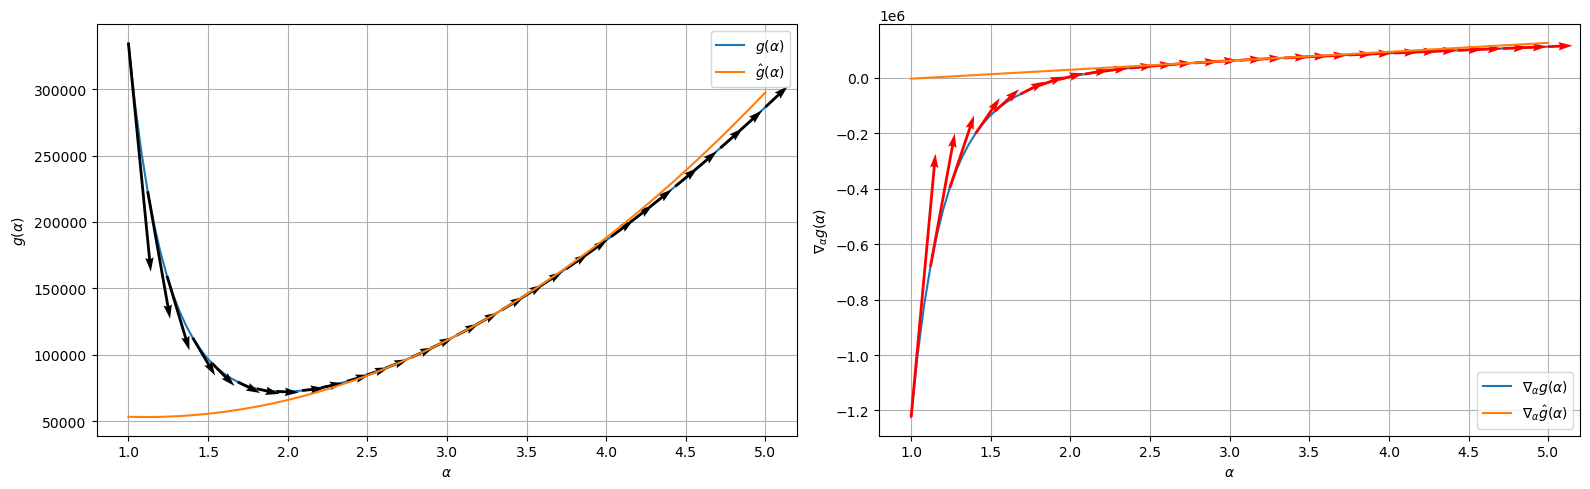

In [332]:
def test_function(dt, alpha, x_vec):
    cost = f(dt, alpha * x_vec)
    return 1 / 2 * np.linalg.norm(cost)**2

def test_function_grad(dt, alpha, x_vec):
    cost = f(dt, alpha * x_vec)
    jacobian = Df(dt, alpha * x_vec)
    return cost.T @ jacobian @ x_vec

def test_function_hessian(dt, alpha, x_vec):
    n = len(x_vec)
    cost = f(dt, alpha * x_vec)
    jacobian = Df(dt, alpha * x_vec)
    hessian = Hf(dt, alpha * x_vec)
    return cost.T @ np.kron(x_vec, np.eye(n)).T @ hessian @ x_vec + x_vec.T @ jacobian.T @ jacobian @ x_vec

def test_function_approx(dt, alpha, x_vec, point=0):
    return test_function(dt, point, x_vec) + (alpha - point) * test_function_grad(dt, point, x_vec) + (alpha - point)**2 / 2 * test_function_hessian(dt, point, x_vec)

def test_function_approx_grad(dt, alpha, x_vec, point=0):
    return test_function_grad(dt, point, x_vec) + (alpha - point) * test_function_hessian(dt, point, x_vec)

std = 1e0
sample_x_vec = np.random.multivariate_normal(mean=np.zeros(24,), cov=std*np.eye(24)).reshape((24, 1))

dt = 60.0
alpha_bounds = np.linspace(1e0, 5e0, 100)
cost_values = np.array([test_function(dt, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
gradient_values = np.array([test_function_grad(dt, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
hessian_values = np.array([test_function_hessian(dt, alpha, sample_x_vec).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_cost_function = np.array([test_function_approx(dt, alpha, sample_x_vec, point=np.mean(alpha_bounds)).flatten() for alpha in alpha_bounds])
taylor_series_second_order_expansion_cost_function_grad = np.array([test_function_approx_grad(dt, alpha, sample_x_vec, point=np.mean(alpha_bounds)).flatten() for alpha in alpha_bounds])

# Arrows
num_arrows = 30
arrow_indices = np.linspace(0, len(alpha_bounds) - 1, num_arrows, dtype=int)

# Plot function and gradient
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Function and gradient arrows
axes[0].plot(alpha_bounds, cost_values, label=r'$g(\alpha)$')
axes[0].quiver(alpha_bounds[arrow_indices], cost_values[arrow_indices], 
               np.ones_like(arrow_indices), gradient_values[arrow_indices], 
               angles='xy', scale_units='xy', color='black', width=0.004, zorder=2)
axes[0].plot(alpha_bounds, taylor_series_second_order_expansion_cost_function, label=r'$\hat{g}(\alpha)$', zorder=3)
axes[0].set_xlabel(r'$\alpha$')
axes[0].set_ylabel(r'$g(\alpha)$')
axes[0].grid()
axes[0].legend()

# Right plot: Gradient and Hessian arrows
axes[1].plot(alpha_bounds, gradient_values, label=r'$\nabla_\alpha g(\alpha)$')
axes[1].quiver(alpha_bounds[arrow_indices], gradient_values[arrow_indices], 
               np.ones_like(arrow_indices), hessian_values[arrow_indices], 
               angles='xy', scale_units='xy', color='red', width=0.004, zorder=2)
axes[1].plot(alpha_bounds, taylor_series_second_order_expansion_cost_function_grad, label=r'$\nabla_\alpha \hat{g}(\alpha)$', zorder=3)
axes[1].set_xlabel(r'$\alpha$')
axes[1].set_ylabel(r'$\nabla_\alpha g(\alpha)$')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()